In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('mathtext', default='regular')

In [2]:
os.chdir('/Users/jeetoza/Desktop/Algo trading')
cwd = os.getcwd()
print(cwd)

/Users/jeetoza/Desktop/Algo trading


In [3]:
def drift_price(Mid, Drifts):
    price = Mid 
    for i in range(len(Drifts)):
        price += (0.5)**i * Drifts[i]
    return price

In [4]:
def TWAP_Trade_Cost(Date, shares, ticker, bins, interval = 1):
    total_shares = shares
    trades = []
    total_price = 0
    total_drifted_price = 0
    format = "%Y%m%d %H%M"
    Drifts = [0, 0, 0, 0, 0, 0]
    start = pd.to_datetime(Date + " 1030", format=format) #Trade starts at 10:30
    end = pd.to_datetime(Date + " 1600", format=format)
    file = "S&P500 - Q4 2018/allstocks_" + Date + "/table_" + ticker + ".csv"
    if (os.path.exists(file) == 0):
        print("Bad Date = ", Date)

    data = pd.read_csv(file, header = None,
                       names=["Date", "Time", "Open", "High", 'Low', "Close", "Volume", "a", "b", "c"],
                       parse_dates=[['Date', 'Time']]) 
    data["DateTime"] = pd.to_datetime(data.Date_Time, format=format)
    data["Mid"] = (data["High"] + data["Low"] + data["Open"] + data["Close"]) / 4
    
    data = data[["DateTime", "Open", "High", "Low", "Close", "Mid", "Volume"]]
    filtered_data = data[(data.DateTime >= start) & (data.DateTime <= end)]
    filtered_data = filtered_data.reset_index(drop=True)
    curr_price = filtered_data.Mid[0]
    total_price = 0
    total_drifted_price = 0
    Highest_Price = curr_price
    n_bins = min(bins,data.shape[0])
    nb_trades = np.floor(n_bins/interval)
    Volume_Trade_Size = np.floor(1.*total_shares / (nb_trades))+1
    count = 0

    for row in filtered_data.itertuples():
        if(count%interval != 0):
            continue
        Volume = row.Volume
        traded_Volume = min(Volume_Trade_Size, shares)
        Mid_price = row.Mid
        Drifts.insert(0,0.2*(np.sqrt(traded_Volume/Volume))*(row.High - row.Mid))
        Drifts.pop(-1)
        drifted_price = drift_price(Mid_price, Drifts)
        if(drifted_price > Highest_Price):
            Highest_Price = drifted_price
        trades.append({"Time" : row.DateTime, "Volume" : traded_Volume, "Price" : Mid_price, 
                       "Drifted_Price": drifted_price, "actual_Volume" : Volume})
        total_price += traded_Volume * Mid_price
        total_drifted_price += traded_Volume * drifted_price
        shares -= traded_Volume
        count += 1
        if(shares == 0):
            break
        
    Price_Per_Share = total_price / (total_shares - shares)
    Drifted_Price_Per_Share = total_drifted_price / (total_shares - shares)
    rtn = {"Total_Price" : total_price, "Price_Per_Share" : Price_Per_Share, 
           "Total_Drifted_Price" : total_drifted_price, "Drifted_Price_Per_Share" : Drifted_Price_Per_Share, 
           "Price_Impact" : Drifted_Price_Per_Share - curr_price,
           "Price_Impact(bps)" : (Drifted_Price_Per_Share - curr_price)*10000 / curr_price,
           "Trades" : pd.DataFrame(trades),
           "Shortfall" : shares, "filtered_data" : filtered_data, 
           "Highest_Price" : Highest_Price}
    return rtn
TWAP_result = TWAP_Trade_Cost("20181010", 3e6, "AAPL", 330)
print("average traded price : ", TWAP_result[ "Price_Per_Share" ])
print("average drifted price :", TWAP_result[ "Drifted_Price_Per_Share" ])
print("PI :", TWAP_result[ "Price_Impact(bps)" ])

print(TWAP_result[ "Trades" ])

average traded price :  220.566083381
average drifted price : 220.590275815
PI : -57.5221669559
     Drifted_Price      Price                Time  Volume  actual_Volume
0       221.887681  221.86650 2018-10-10 10:30:00  9091.0       111862.0
1       222.108802  222.08250 2018-10-10 10:31:00  9091.0        56306.3
2       221.935969  221.90100 2018-10-10 10:32:00  9091.0        54867.2
3       221.745502  221.70500 2018-10-10 10:33:00  9091.0        38227.6
4       221.673997  221.63950 2018-10-10 10:34:00  9091.0        69179.9
5       221.656511  221.62575 2018-10-10 10:35:00  9091.0        69084.1
6       221.750088  221.71975 2018-10-10 10:36:00  9091.0        76156.8
7       221.888720  221.85650 2018-10-10 10:37:00  9091.0        60715.4
8       221.889300  221.85775 2018-10-10 10:38:00  9091.0        48504.0
9       221.731842  221.70300 2018-10-10 10:39:00  9091.0        38970.3
10      221.724076  221.69775 2018-10-10 10:40:00  9091.0        51446.8
11      221.763731  221.7397

In [5]:
def function_tilt(x,t = 0, fast_pace = 2, tilt = 0, random = False):
    if(random):
        return(2*x*np.random.uniform(0,1))
    else:
        return(fast_pace*x + tilt*t)

In [6]:
def Tilted_TWAP_Trade_Cost(Date, shares, ticker, bins, interval = 1, pct_trigger = 0.3, fast_pace = 2):
    total_shares = shares
    trades = []
    total_price = 0
    total_drifted_price = 0
    format = "%Y%m%d %H%M"
    Drifts = [0, 0, 0, 0, 0, 0]
    start = pd.to_datetime(Date + " 1030", format=format) #Trade starts at 10:30
    end = pd.to_datetime(Date + " 1600", format=format)
    file = "S&P500 - Q4 2018/allstocks_" + Date + "/table_" + ticker + ".csv"
    if (os.path.exists(file) == 0):
        print("Bad Date = ", Date)

    data = pd.read_csv(file, header = None,
                       names=["Date", "Time", "Open", "High", 'Low', "Close", "Volume", "a", "b", "c"],
                       parse_dates=[['Date', 'Time']]) 
    data["DateTime"] = pd.to_datetime(data.Date_Time, format=format)
    data["Mid"] = (data["High"] + data["Low"] + data["Open"] + data["Close"]) / 4
    
    data = data[["DateTime", "Open", "High", "Low", "Close", "Mid", "Volume"]]
    filtered_data = data[(data.DateTime >= start) & (data.DateTime <= end)]
    filtered_data = filtered_data.reset_index(drop=True)
    curr_price = filtered_data.Mid[0]
    total_price = 0
    total_drifted_price = 0
    Highest_Price = curr_price
    n_bins = min(bins,data.shape[0])
    nb_trades = np.floor(n_bins/interval)
    slice_size = np.floor(1.*total_shares / (nb_trades))+1

    count = 0
    triggered = False
    tilt = 1
    prct_trigger = 0.3
    fast_pace = 2

    for row in filtered_data.itertuples():
        if(count%interval != 0):
            count += 1
            continue
        if(triggered):
            Volume_Trade_Size = function_tilt(slice_size)
        else:
            Volume_Trade_Size = slice_size
        Volume = row.Volume
        traded_Volume = min(Volume_Trade_Size, shares)
        Mid_price = row.Mid
        Drifts.insert(0,0.2*(np.sqrt(traded_Volume/Volume))*(row.High - row.Mid))
        Drifts.pop(-1)
        drifted_price = drift_price(Mid_price, Drifts)
        if(drifted_price > Highest_Price):
            Highest_Price = drifted_price
        trades.append({"Time" : row.DateTime, "Volume" : traded_Volume, "Price" : Mid_price, 
                       "Drifted_Price": drifted_price, "actual_Volume" : Volume})
        total_price += traded_Volume * Mid_price
        total_drifted_price += traded_Volume * drifted_price
        shares -= traded_Volume
        count += 1
        if(shares <= (1 - pct_trigger)*total_shares):
            triggered = True
        if(shares == 0):
            break
        
    Price_Per_Share = total_price / (total_shares - shares)
    Drifted_Price_Per_Share = total_drifted_price / (total_shares - shares)
    rtn = {"Total_Price" : total_price, "Price_Per_Share" : Price_Per_Share, 
           "Total_Drifted_Price" : total_drifted_price, "Drifted_Price_Per_Share" : Drifted_Price_Per_Share, 
           "Price_Impact" : Drifted_Price_Per_Share - curr_price,
           "Price_Impact(bps)" : (Drifted_Price_Per_Share - curr_price)*10000 / curr_price,
           "Trades" : pd.DataFrame(trades),
           "Shortfall" : shares, "filtered_data" : filtered_data, 
           "Highest_Price" : Highest_Price}
    return rtn
tilted_TWAP_result = Tilted_TWAP_Trade_Cost("20181010", 3e6, "AAPL", 330,1)
print("average traded price : ", tilted_TWAP_result[ "Price_Per_Share" ])
print("average drifted price :", tilted_TWAP_result[ "Drifted_Price_Per_Share" ])
print(tilted_TWAP_result[ "Trades" ])

average traded price :  221.493768626
average drifted price : 221.52519654
     Drifted_Price      Price                Time   Volume  actual_Volume
0       221.887681  221.86650 2018-10-10 10:30:00   9091.0       111862.0
1       222.108802  222.08250 2018-10-10 10:31:00   9091.0        56306.3
2       221.935969  221.90100 2018-10-10 10:32:00   9091.0        54867.2
3       221.745502  221.70500 2018-10-10 10:33:00   9091.0        38227.6
4       221.673997  221.63950 2018-10-10 10:34:00   9091.0        69179.9
5       221.656511  221.62575 2018-10-10 10:35:00   9091.0        69084.1
6       221.750088  221.71975 2018-10-10 10:36:00   9091.0        76156.8
7       221.888720  221.85650 2018-10-10 10:37:00   9091.0        60715.4
8       221.889300  221.85775 2018-10-10 10:38:00   9091.0        48504.0
9       221.731842  221.70300 2018-10-10 10:39:00   9091.0        38970.3
10      221.724076  221.69775 2018-10-10 10:40:00   9091.0        51446.8
11      221.763731  221.73975 2018-10

     Drifted_Price      Price                Time   Volume  actual_Volume
0       221.887681  221.86650 2018-10-10 10:30:00   9091.0       111862.0
1       222.108802  222.08250 2018-10-10 10:31:00   9091.0        56306.3
2       221.935969  221.90100 2018-10-10 10:32:00   9091.0        54867.2
3       221.745502  221.70500 2018-10-10 10:33:00   9091.0        38227.6
4       221.673997  221.63950 2018-10-10 10:34:00   9091.0        69179.9
5       221.656511  221.62575 2018-10-10 10:35:00   9091.0        69084.1
6       221.750088  221.71975 2018-10-10 10:36:00   9091.0        76156.8
7       221.888720  221.85650 2018-10-10 10:37:00   9091.0        60715.4
8       221.889300  221.85775 2018-10-10 10:38:00   9091.0        48504.0
9       221.731842  221.70300 2018-10-10 10:39:00   9091.0        38970.3
10      221.724076  221.69775 2018-10-10 10:40:00   9091.0        51446.8
11      221.763731  221.73975 2018-10-10 10:41:00   9091.0        59644.1
12      221.707285  221.68625 2018-10-

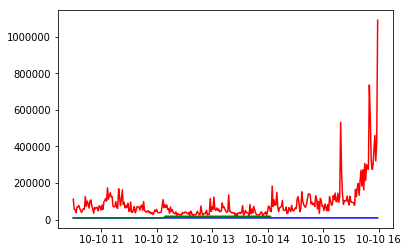

In [7]:
TWAP = TWAP_result[ "Trades" ]
tilted_TWAP = tilted_TWAP_result[ "Trades" ]
print(tilted_TWAP)
plt.plot(TWAP.Time,TWAP.Volume, color = 'b')
plt.plot(TWAP.Time,TWAP.actual_Volume, color = 'r')
plt.plot(tilted_TWAP.Time,tilted_TWAP.Volume, color = 'g')

plt.show()

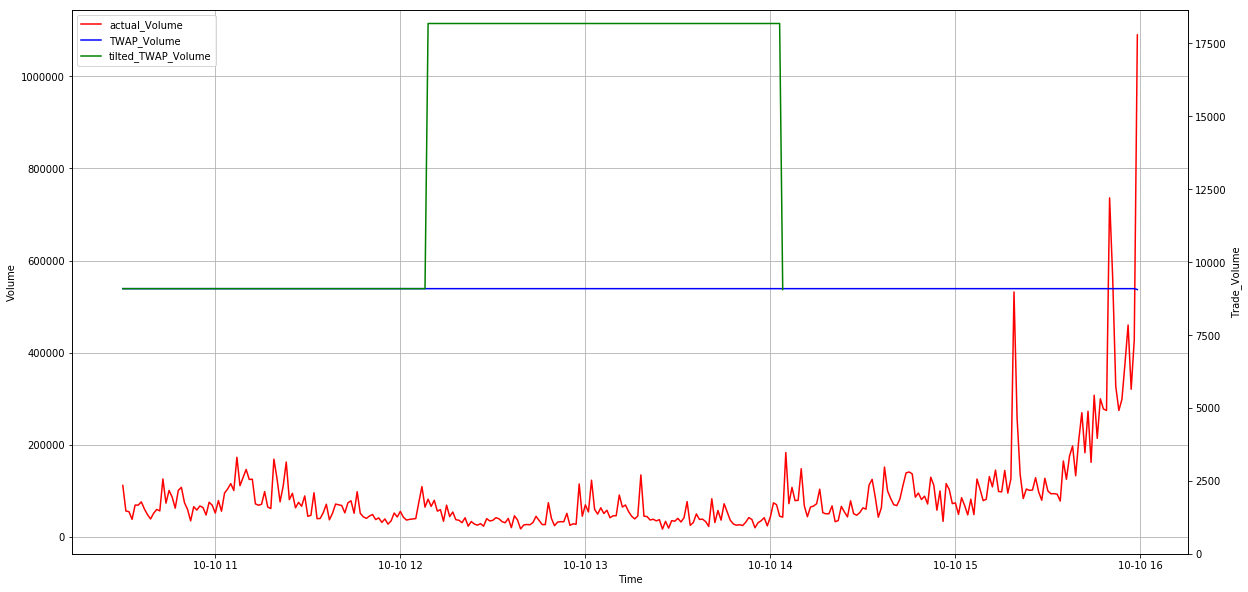

In [8]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

lns1 = ax.plot(TWAP.Time,TWAP.actual_Volume, color = 'r', label = 'actual_Volume')
ax2 = ax.twinx()
lns2 = ax2.plot(TWAP.Time,TWAP.Volume, color = 'b', label = 'TWAP_Volume')
lns3 = ax2.plot(tilted_TWAP.Time,tilted_TWAP.Volume, color = 'g', label = 'tilted_TWAP_Volume')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Volume")
ax2.set_ylabel("Trade_Volume")
ax2.set_ylim(bottom=0)

plt.show()

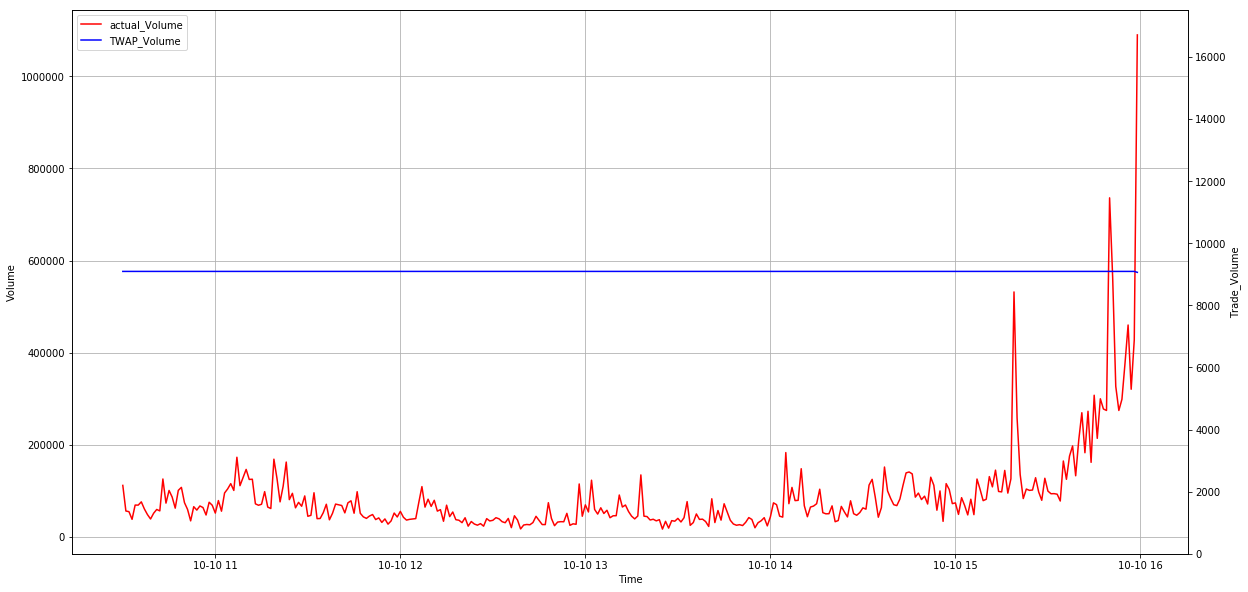

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

lns1 = ax.plot(TWAP.Time,TWAP.actual_Volume, color = 'r', label = 'actual_Volume')
ax2 = ax.twinx()
lns2 = ax2.plot(TWAP.Time,TWAP.Volume, color = 'b', label = 'TWAP_Volume')
#lns3 = ax2.plot(tilted_TWAP.Time,tilted_TWAP.Volume, color = 'g', label = 'tilted_TWAP_Volume')

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Volume")
ax2.set_ylabel("Trade_Volume")
ax2.set_ylim(bottom=0,top=17500)

plt.show()

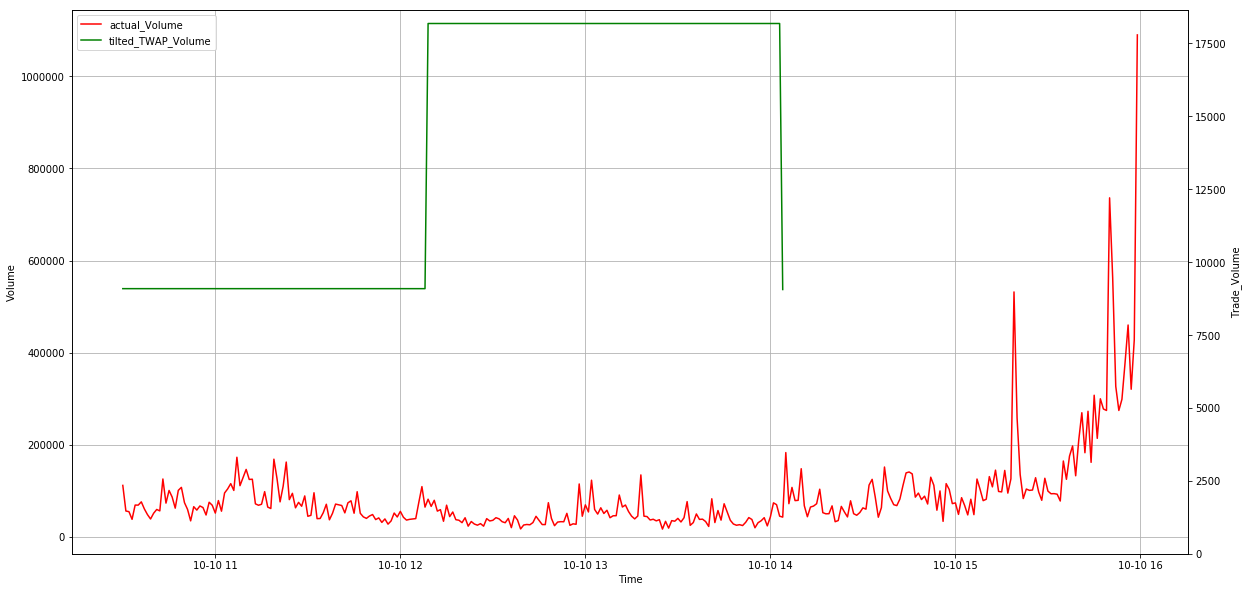

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

lns1 = ax.plot(TWAP.Time,TWAP.actual_Volume, color = 'r', label = 'actual_Volume')
ax2 = ax.twinx()
#lns2 = ax2.plot(TWAP.Time,TWAP.Volume, color = 'b', label = 'TWAP_Volume')
lns3 = ax2.plot(tilted_TWAP.Time,tilted_TWAP.Volume, color = 'g', label = 'tilted_TWAP_Volume')

# added these three lines
lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Volume")
ax2.set_ylabel("Trade_Volume")
ax2.set_ylim(bottom=0)

plt.show()